Synthentic dataset for building operations
----
Author(s): Akash Mahajan, Van-Hai Bui

This code generates the synthetic dataset that is used for simulating the building operations. This dataset is used to study the performance of BNN and MC-LSTM probabilistic models in the paper titled [Bayesian Neural Network-Based Approach for Probabilistic Prediction of Building Energy Demands](https://www.preprints.org/manuscript/202409.2211/v1)

In [10]:
# Importing required packages
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import json

In [11]:
# Generate timeframe (index of the time series)
start_date = datetime(2021, 1, 1)  # Starting date
end_date = datetime(2024, 1, 1)    # Ending date (3 years)
timestamps = pd.date_range(start=start_date, end=end_date, freq='h')[:-1]  # hourly frequency

# Initialize DataFrame
data = pd.DataFrame({"timestamp": timestamps})

In [12]:
# Helper functions
def get_season(month):
    """
    for a given month, identify the season to which it falls in.
    """
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:
        return "autumn"

# Define weekend and duty hours
data["season"] = data["timestamp"].dt.month.apply(get_season)

In [13]:
# Whether the current weekday is a weekend?
data["weekend_status"] = data["timestamp"].dt.weekday >= 5  # True if Saturday or Sunday

In [14]:
# Let's assume the building's official hours are from 8 AM to 5 PM (8:00 to 17:00 according to Military time)
data["duty_status"] = data["timestamp"].dt.hour.between(8, 17)  # True if 8:00 to 17:00

In [15]:
# events in progress
np.random.seed(0)   # seed the numpy to able to reproduce similar randomness
data["event_in_progress"] = np.random.choice([False, True], size=len(data), p=[0.95, 0.05])   # 5% chance of occuring an event on a particular day

In [16]:
# Interior zone temperature
base_temp = {"winter": 18, 
             "spring": 20, 
             "summer": 24, 
             "autumn": 20}   # baseline temperature in each season

temp_amplitude = {"winter": 4, 
                  "spring": 3,
                  "summer": 5,
                  "autumn": 3}  # the range in which the values varies during a season

data["interior_zone_temp"] = [
    base_temp[get_season(ts.month)] + temp_amplitude[get_season(ts.month)] * np.sin(2 * np.pi * ts.hour / 24) + np.random.normal(0, 0.5) for ts in data["timestamp"]
]

In [17]:
# Solar radiation: varies with season and time of day (max around noon in summer)
data["solar_radiation"] = [
    max(0, 500 * np.sin(2 * np.pi * (ts.hour - 6) / 24) * (1 if get_season(ts.month) == "summer" else 0.5) + np.random.normal(0, 50)) for ts in data["timestamp"]
]

In [18]:
# Relative humidity: inversely related to temperature, with some random variation
data["relative_humidity"] = [
    50 + (10 if get_season(ts.month) in ["winter", "spring"] else -10) + np.random.normal(0, 5) for ts in data["timestamp"]
]

In [19]:
# Air temperature
outdoor_base_temp = {"winter": 5,
                     "spring": 15,
                     "summer": 30,
                     "autumn": 15}

data["air_temp"] = [
    outdoor_base_temp[get_season(ts.month)] + temp_amplitude[get_season(ts.month)] * np.sin(2 * np.pi * ts.hour / 24) + np.random.normal(0, 2) for ts in data["timestamp"]
]

In [20]:
# Wind speed
wind_speed_base = {"winter": 15,
                   "spring": 10,
                   "summer": 7,
                   "autumn": 10}

data["wind_speed"] = [
    wind_speed_base[get_season(ts.month)] + np.random.normal(0, 3) for ts in data["timestamp"]
]

In [21]:
# Electricity load
electricity_base = {"winter": 120,
                    "spring": 100,
                    "summer": 150,
                    "autumn": 110}   # Minimum electricity consumption for each season

data["elec"] = [
    electricity_base[get_season(row["timestamp"].month)] * (1.2 if row["duty_status"] else 0.8) * (0.5 if row["weekend_status"] else 1.0) + np.random.normal(0, 10) for _, row in data.iterrows()
]

In [22]:
# HVAC load
# increases with higher interior temperature and if duty status is True

data["hvac"] = [
    max(0, (0.5 * row["interior_zone_temp"] + 0.25 * row["elec"] + (10 if row["duty_status"] else 2)) + np.random.normal(0, 2)) for _, row in data.iterrows()
]

In [23]:
data.head()

,timestamp,season,weekend_status,duty_status,event_in_progress,interior_zone_temp,solar_radiation,relative_humidity,air_temp,wind_speed,elec,hvac
0,2021-01-01 00:00:00,winter,False,False,False,18.618132,0.0,61.143058,3.204335,17.977553,108.935233,36.838953
1,2021-01-01 01:00:00,winter,False,False,False,19.079020,0.0,59.480274,7.814820,16.403133,96.044572,37.393733
2,2021-01-01 02:00:00,winter,False,False,False,20.211322,0.0,63.876394,7.447940,16.341190,119.520583,40.841474
3,2021-01-01 03:00:00,winter,False,False,False,20.864618,0.0,58.484689,12.810814,12.883575,121.965148,41.559299
4,2021-01-01 04:00:00,winter,False,False,False,21.417821,0.0,59.636680,9.263461,13.808086,89.223260,39.221164


### General data preprocessing

In [24]:
data.set_index("timestamp",inplace=True)
# Preprocessing
data_copy=data[['interior_zone_temp','solar_radiation','relative_humidity', 'air_temp', 'wind_speed', 'elec','hvac']].copy()

In [25]:
data_copy.head()

,interior_zone_temp,solar_radiation,relative_humidity,air_temp,wind_speed,elec,hvac
timestamp,,,,,,,
2021-01-01 00:00:00,18.618132,0.0,61.143058,3.204335,17.977553,108.935233,36.838953
2021-01-01 01:00:00,19.079020,0.0,59.480274,7.814820,16.403133,96.044572,37.393733
2021-01-01 02:00:00,20.211322,0.0,63.876394,7.447940,16.341190,119.520583,40.841474
2021-01-01 03:00:00,20.864618,0.0,58.484689,12.810814,12.883575,121.965148,41.559299
2021-01-01 04:00:00,21.417821,0.0,59.636680,9.263461,13.808086,89.223260,39.221164


In [26]:
def get_dummies(series: pd.Series, column_names: list):
    # Convert a time series of discrete values to a one-hot encoded vectors
    dummy_df = pd.get_dummies(series).astype(np.int32)
    if len(column_names) == dummy_df.shape[-1]:
        dummy_df.columns = column_names
    else:
        raise Error("Length of column names list does not match the number of dummy variables")
        return pd.DataFrame(data=None)
    return dummy_df

In [27]:
# preprocess the weekend status feature
is_weekend_weekday=get_dummies(data["weekend_status"],["is_weekday","is_weekend"])
data_copy=pd.concat((data_copy,is_weekend_weekday),axis=1)

In [28]:
data_copy.head()

,interior_zone_temp,solar_radiation,relative_humidity,air_temp,wind_speed,elec,hvac,is_weekday,is_weekend
timestamp,,,,,,,,,
2021-01-01 00:00:00,18.618132,0.0,61.143058,3.204335,17.977553,108.935233,36.838953,1,0
2021-01-01 01:00:00,19.079020,0.0,59.480274,7.814820,16.403133,96.044572,37.393733,1,0
2021-01-01 02:00:00,20.211322,0.0,63.876394,7.447940,16.341190,119.520583,40.841474,1,0
2021-01-01 03:00:00,20.864618,0.0,58.484689,12.810814,12.883575,121.965148,41.559299,1,0
2021-01-01 04:00:00,21.417821,0.0,59.636680,9.263461,13.808086,89.223260,39.221164,1,0


In [29]:
# preprocess season feature
season_names = ["is_spring", "is_summer", "is_autumn", "is_winter"]
season_of_year = get_dummies(data["season"], season_names)
data_copy=pd.concat((data_copy,season_of_year),axis=1)

In [30]:
# proprocess the duty status feature
work_hour=get_dummies(data['duty_status'],["is_off_duty", "is_on_duty"])
data_copy=pd.concat((data_copy, work_hour), axis=1)
data_copy.head()

,interior_zone_temp,solar_radiation,relative_humidity,air_temp,wind_speed,elec,hvac,is_weekday,is_weekend,is_spring,is_summer,is_autumn,is_winter,is_off_duty,is_on_duty
timestamp,,,,,,,,,,,,,,,
2021-01-01 00:00:00,18.618132,0.0,61.143058,3.204335,17.977553,108.935233,36.838953,1,0,0,0,0,1,1,0
2021-01-01 01:00:00,19.079020,0.0,59.480274,7.814820,16.403133,96.044572,37.393733,1,0,0,0,0,1,1,0
2021-01-01 02:00:00,20.211322,0.0,63.876394,7.447940,16.341190,119.520583,40.841474,1,0,0,0,0,1,1,0
2021-01-01 03:00:00,20.864618,0.0,58.484689,12.810814,12.883575,121.965148,41.559299,1,0,0,0,0,1,1,0
2021-01-01 04:00:00,21.417821,0.0,59.636680,9.263461,13.808086,89.223260,39.221164,1,0,0,0,0,1,1,0


In [31]:
# Rearrange the features and targets
data_copy=data_copy[['interior_zone_temp', 'solar_radiation', 'relative_humidity', 'air_temp',
                     'wind_speed', 'is_weekday', 'is_weekend', 'is_spring', 'is_summer', 'is_autumn', 'is_winter',
                     'is_off_duty', 'is_on_duty', 'elec', 'hvac']]

In [32]:
data_copy.head()

,interior_zone_temp,solar_radiation,relative_humidity,air_temp,wind_speed,is_weekday,is_weekend,is_spring,is_summer,is_autumn,is_winter,is_off_duty,is_on_duty,elec,hvac
timestamp,,,,,,,,,,,,,,,
2021-01-01 00:00:00,18.618132,0.0,61.143058,3.204335,17.977553,1,0,0,0,0,1,1,0,108.935233,36.838953
2021-01-01 01:00:00,19.079020,0.0,59.480274,7.814820,16.403133,1,0,0,0,0,1,1,0,96.044572,37.393733
2021-01-01 02:00:00,20.211322,0.0,63.876394,7.447940,16.341190,1,0,0,0,0,1,1,0,119.520583,40.841474
2021-01-01 03:00:00,20.864618,0.0,58.484689,12.810814,12.883575,1,0,0,0,0,1,1,0,121.965148,41.559299
2021-01-01 04:00:00,21.417821,0.0,59.636680,9.263461,13.808086,1,0,0,0,0,1,1,0,89.223260,39.221164


In [33]:
df_new=data_copy.copy()

In [34]:
def standardize(y: pd.Series):
    y_mean = y.mean()
    y_std = y.std()
    y = (y - y_mean) / y_std
    return y, y_mean, y_std

# log transformation of the elec and hvac series
df_new["elec"] = np.log(df_new["elec"] + 1e-1)
df_new["hvac"] = np.log(df_new["hvac"] + 1e-1)

stats = {}

y = df_new["elec"]
elec_kW, elec_kW_mean, elec_kW_std = standardize(y)
stats["elec_mean"] = elec_kW_mean   # Used later for inverse transformation process during evaluation
stats["elec_std"] = elec_kW_std

y = df_new["hvac"]
hvac_kW, hvac_kW_mean, hvac_kW_std = standardize(y)
stats["hvac_mean"] = hvac_kW_mean
stats["hvac_std"] = hvac_kW_std

df_new["elec"] = elec_kW
df_new["hvac"] = hvac_kW

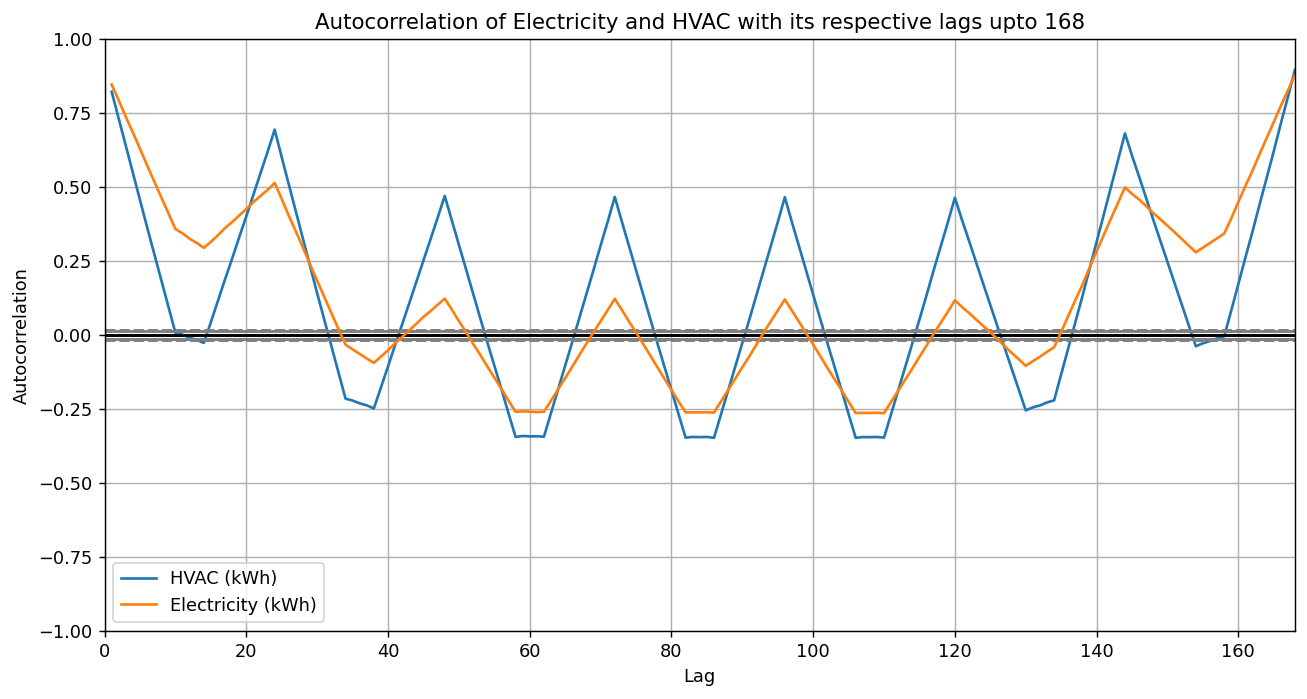

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6)).set_dpi(128)
y = df_new["hvac"].copy()
pd.plotting.autocorrelation_plot(y, label="HVAC (kWh)")
y = df_new["elec"].copy()
pd.plotting.autocorrelation_plot(y, label="Electricity (kWh)")
plt.title("Autocorrelation of Electricity and HVAC with its respective lags upto 168")
plt.xlim([0, 168])
plt.legend()
plt.grid(True)
plt.show()

In [36]:
lags = [24, 168]   # for electricity and HVAC, lag 24 and lag 168 has higher correlation compared to other lags
lag_timediff = {}

for lag in lags: 
    timediff = lag * np.ones(shape = (df_new.shape[0],))
    # Deal with first 'lag' entries
    for i , diff in enumerate(timediff[:lag + 1]):
        timediff[i] = min(diff, i)
    lag_timediff[lag] = timediff

In [37]:
df_new_index = df_new.index
df_new_copy = df_new.copy()

for target in ["elec", "hvac"]:
    for lag, timediff in lag_timediff.items():
        y = df_new[[target]].copy()
        latest_lag_index = df_new_index - pd.to_timedelta(timediff, unit='H')
        latest_lag = y.loc[latest_lag_index].copy()
        latest_lag.index = df_new_index
        latest_lag = latest_lag.add_prefix(f'lag_{lag}_')
        df_new_copy = pd.concat([latest_lag, df_new_copy], axis=1)

In [38]:
df_new_copy

,lag_168_hvac,lag_24_hvac,lag_168_elec,lag_24_elec,interior_zone_temp,solar_radiation,relative_humidity,air_temp,wind_speed,is_weekday,is_weekend,is_spring,is_summer,is_autumn,is_winter,is_off_duty,is_on_duty,elec,hvac
timestamp,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,-0.133886,-0.133886,0.407917,0.407917,18.618132,0.0,61.143058,3.204335,17.977553,1,0,0,0,0,1,1,0,0.407917,-0.133886
2021-01-01 01:00:00,-0.133886,-0.133886,0.407917,0.407917,19.079020,0.0,59.480274,7.814820,16.403133,1,0,0,0,0,1,1,0,0.116210,-0.087391
2021-01-01 02:00:00,-0.133886,-0.133886,0.407917,0.407917,20.211322,0.0,63.876394,7.447940,16.341190,1,0,0,0,0,1,1,0,0.622733,0.186986
2021-01-01 03:00:00,-0.133886,-0.133886,0.407917,0.407917,20.864618,0.0,58.484689,12.810814,12.883575,1,0,0,0,0,1,1,0,0.669635,0.241198
2021-01-01 04:00:00,-0.133886,-0.133886,0.407917,0.407917,21.417821,0.0,59.636680,9.263461,13.808086,1,0,0,0,0,1,1,0,-0.054409,0.061039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-1.626579,-2.180761,-1.235616,-1.443015,13.937923,0.0,56.379008,0.980060,15.162791,0,1,0,0,0,1,1,0,-2.145619,-1.963058
2023-12-31 20:00:00,-1.013979,-1.081140,-1.306735,-1.086043,14.490920,0.0,62.432735,2.842187,12.048778,0,1,0,0,0,1,1,0,-1.691727,-1.996085
2023-12-31 21:00:00,-1.603713,-2.238105,-1.039685,-1.461146,14.471728,0.0,63.386142,2.612015,15.686842,0,1,0,0,0,1,1,0,-1.070370,-1.472573


In [39]:
# save the dataset and statistics
import os
target_dir="output"
os.makedirs(target_dir,exist_ok=True)

data_filename=os.path.join(target_dir,"data.csv")
df_new_copy.to_csv(data_filename, index=True)

stats_filename=os.path.join(target_dir,"stats.json")
with open(stats_filename, "w") as file:
    json.dump(stats, file, indent=4)

print("Done")

Done
